# Maps with Cartopy

This tutorial runs through a series of examples that demonstrate how to make maps using data from the Intake Catalog. This tutorial focusses on mapping with `Cartopy`.

Note that these examples are just to give you ideas of how you might be able to make nice maps, but you should expect to adjust and modify to your own use case.

In [1]:
import intake

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import cmocean as cm
import cartopy.crs as ccrs

In [2]:
catalog = intake.cat.access_nri

We will use the SST field from a 0.25° resolution experiment as our sample data. These maps should work with any 2D data.

In [4]:
experiment = "025deg_jra55_iaf_omip2_cycle6"
ds = catalog[experiment].search(variable="sst", frequency="1mon").to_dask()

# convert from degrees K to degrees C
SST = ds.sst.isel(time=0) - 273.15

SST

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.DataArray 'sst' (yt_ocean: 1080, xt_ocean: 1440)> Size: 6MB
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    time      datetime64[ns] 8B 1958-01-14T12:00:00

## Vanilla `.plot()`

You can always make a vanilla plot of this data using `xarray`...

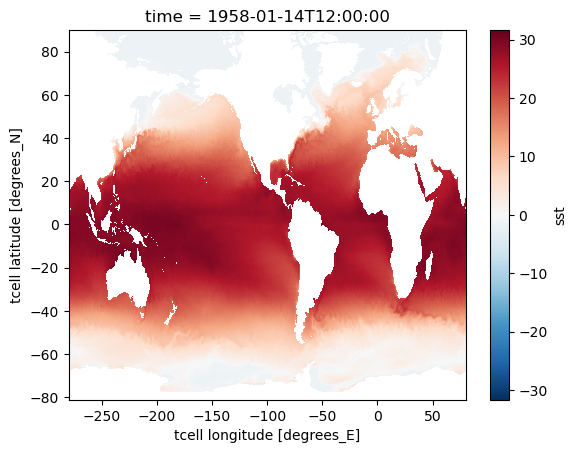

In [5]:
SST.plot();

..., but this doesn't look that appealing. Or, let's just make a subjective remark: it doesn't seem publication-worthy. `:)`

Also, note that there is (objectively) *noticable* distortion in the Arctic ocean, i.e., north of 65°N. (For example, with the current plate-tectonics configuration, Canada does not touch the North Pole as the figure might imply.)

Why is that? The grid that ocean models use diverts from a regular latitude-longitude grid close to the poles, particularly in the Arctic ocean, to avoid the Pole singularity. MOM5 and MOM6 use a grid which replaces the North Pole with two displaced poles: one inside Russia and one inside Canada. That's why often this grid is referred to as "tripolar" grid (South Pole + the two ficticious Poles in Canada and Russia). The coordinates polewards of about 65 degrees become strongly 2D contrary to a latitude-longitude grid where they are not.

## Using Cartopy
Instead, let's plot the same data with cartopy. This example uses the `Robinson` global projection -- but note that key argument in the plot function: `transform=ccrs.PlateCarree()` -- which is needed every time you plot something with cartopy. (Confusingly, you could also use a `PlateCarree` projection, not to be confused with the transformation ...)

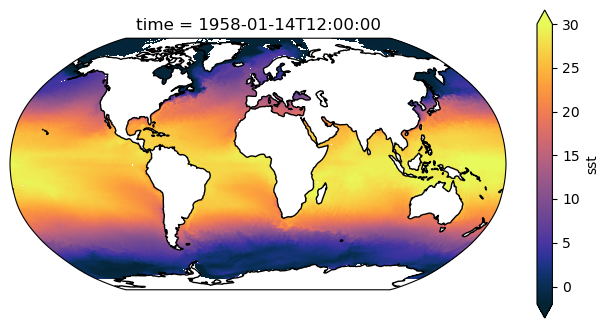

In [6]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())

SST.plot(
    ax=ax,
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
)

ax.coastlines();

You can see that this looks a little better. 

## Colouring in the land
Say, for example, we don't like such a huge colourbar. Also, say we'd prefer the land colour to be something other than white. These details can be dealt with by doing something like the following.

Let's first colour the land.

In [7]:
import cartopy.feature as cft

land_50m = cft.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5
)

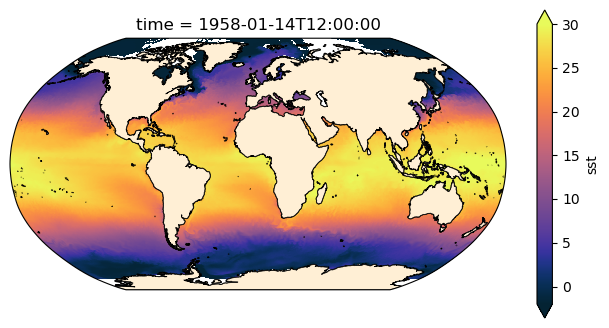

In [8]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())

SST.plot.pcolormesh(
    ax=ax,
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
)

ax.coastlines(resolution="50m")
ax.add_feature(land_50m);

However, there is still a glitch in this plot -- because data in the tripole region is distorted. This occurs because the 1D coordinates `xt_ocean` and `yt_ocean` are actually incorrect in the tripole region. 

## Fixing the tripole
Instead, we need to plot with the 2D arrays of (longitude, latitude) locations -- `geolon_t` and `geolat_t` which we save as static data from each run.

We load `geolon_t` and `geolat_t` and assign these 2D-arrays as coordinates on our data array.

In [17]:
var_search = catalog[experiment].search(variable="area_t")
ds = var_search.search(path=var_search.df["path"][0]).to_dask()
geolon_t = ds.geolon_t
geolat_t = ds.geolat_t

SST = SST.assign_coords({"geolon_t": geolon_t, "geolat_t": geolat_t})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


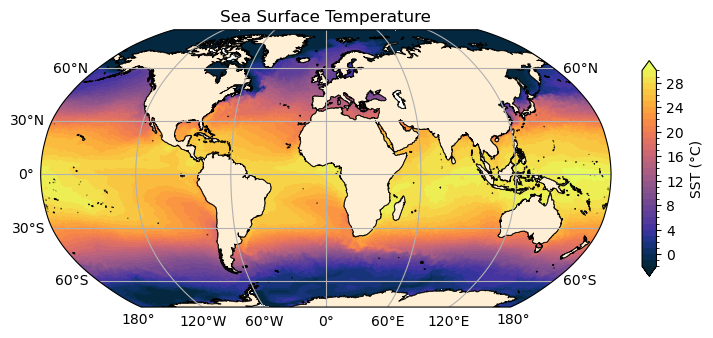

In [13]:
fig = plt.figure(figsize=(8, 4))

ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines(resolution="50m")
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False   # turn off top labels
gl.right_labels = False # turn off right labels

SST.plot.contourf(
    ax=ax,
    x="geolon_t",
    y="geolat_t",
    levels=33,
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)

plt.title("Sea Surface Temperature");

OK, so that's a bit better. We also tweaked the colorbar using `cbar_kwargs`.

But you may have noticed that we had to use `contourf` to make this map: we can't use just `.plot` (which fallsback to `pcolormesh`) in this instance, because `geolon_t` and `geolat_t` we loaded from the model output are masked arrays and `pcolormesh` can't cope with undefined coordinates.
(To convince yourself try `SST.plot(x='geolon_t', y='geolat_t')`.) Our options here are:

- Try `contourf` instead - it should work;
- Use `pcolor`, noting that this is sometimes very slow;
- Read the unmasked 2D longitude/latitude coordinates from a premade netCDF file.

(Note: the coordinates and all ocean variables are masked where there is land to reduce the computations done by the models. For example, we don't need to be computing and updating temperature and velocity values for places in the middle of continents.)

So to demonstrate the last option here we first drop the masked coordinates drom our data array:

In [28]:
SST = SST.drop_vars(["geolon_t", "geolat_t"])

And then load the unmasked ones.

In [29]:
# these lon/lat arrays are NOT masked.
# NB. This is a hack. We would like to improve this.
geolon_t = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc").geolon_t
geolat_t = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc").geolat_t

SST = SST.assign_coords({"geolat_t": geolat_t, "geolon_t": geolon_t})

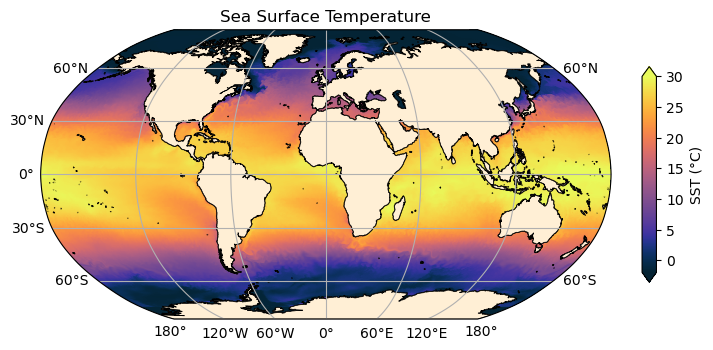

In [30]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines(resolution="50m")
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False   # turn off top labels
gl.right_labels = False # turn off right labels

SST.plot(
    ax=ax,
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)

plt.title("Sea Surface Temperature");

This is about as good as we can get. Note that there are some mismatches between the coastlines in the model and reality, principally around Antarctica and the Canadian Archipelago. Also, note that the `ocean_grid_025.nc` file used here will only work for 0.25° resolution cases - check to see if others are available.

Now that we have a reliable way of using cartopy to plot this data with `cartopy`, the following examples provide some examples of how to configure and tailor your maps ...

## Mark a region

Sometimes we want to mark a particular region that our analysis is foccused on. We can do that using `matplotlib.patches`.

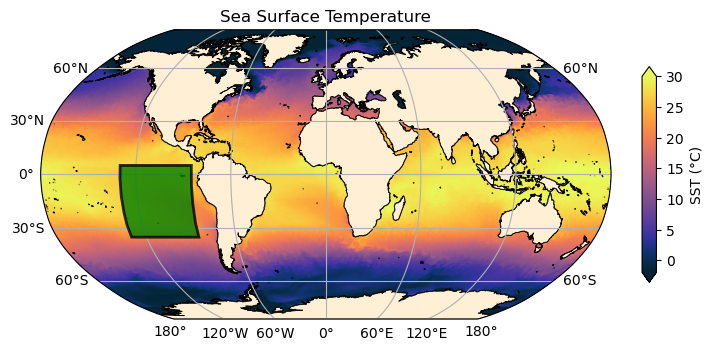

In [33]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines(resolution="50m")
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False   # turn off top labels
gl.right_labels = False # turn off right labels

SST.plot(
    ax=ax,
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)

plt.title("Sea Surface Temperature")

ax.add_patch(
    mpatches.Rectangle(
        xy=[-130, -35],  # the location of the bottom-left corner of the rectangle
        width=45,
        height=40,  # the width and height of the rectange (in degrees)
        facecolor="green",
        edgecolor="black",
        linewidth=2,
        alpha=0.8,
        fill=True,
        zorder=3,  # brings the patch in front
        transform=ccrs.PlateCarree(),
    )
);

## Subplots

It can be a bit tricky to use Cartopy with subplots. Here's an example:

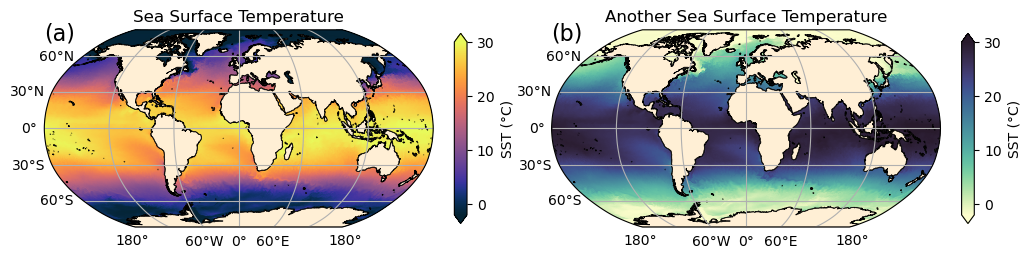

In [35]:
fig, axes = plt.subplots(
    ncols=2, subplot_kw={"projection": ccrs.Robinson()}, figsize=(12, 8)
)

cbar_kwargs = {"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7}

SST.plot(
    ax=axes[0],
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs=cbar_kwargs,
)

SST.plot(
    ax=axes[1],
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.deep,
    cbar_kwargs=cbar_kwargs,
)

import string

# add features and label panels
for n, ax in enumerate(axes):
    # features
    ax.coastlines(resolution="50m")
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # turn off top labels
    gl.right_labels = False # turn off right labels

    # subplot labels
    ax.text(
        0, 0.95, "(" + string.ascii_lowercase[n] + ")", transform=ax.transAxes, size=16
    )

axes[0].set_title("Sea Surface Temperature")
axes[1].set_title("Another Sea Surface Temperature");

## Projections
Here are a few interesting projections you can use with `cartopy` that might be useful for other applications. Note that if you decide to use a map region which extends north of 65°N, you should use the 2D coordinte files as per above.

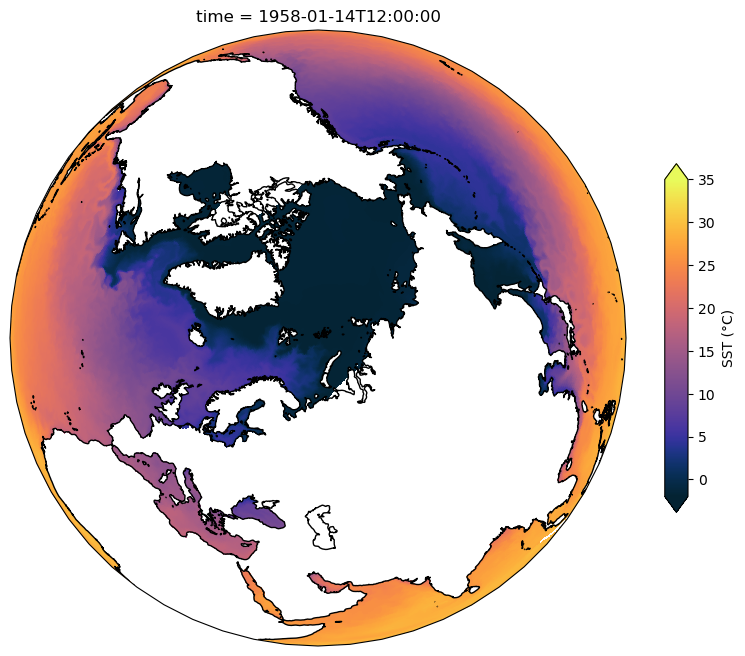

In [15]:
projection = ccrs.Orthographic(central_latitude=80, central_longitude=50)

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=projection)

ax.coastlines(resolution="50m")

SST.plot(
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=35,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

### Near-Sided Perspective

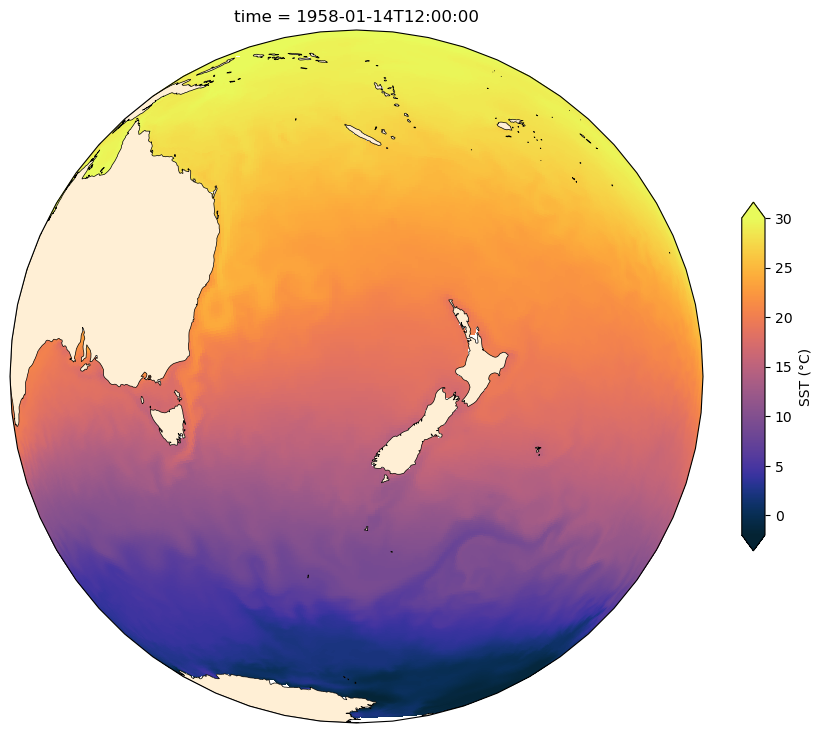

In [16]:
projection = ccrs.NearsidePerspective(
    central_longitude=165.0, central_latitude=-40.0, satellite_height=2500000
)

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)

SST.plot(
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

### South Polar Stereo
Note that this plot, by default, shows the entire globe, which undermines the area of the South Pole region. So, to enhance our beloved Southern Ocean we have to cut an area of the figure to focus down on it. 

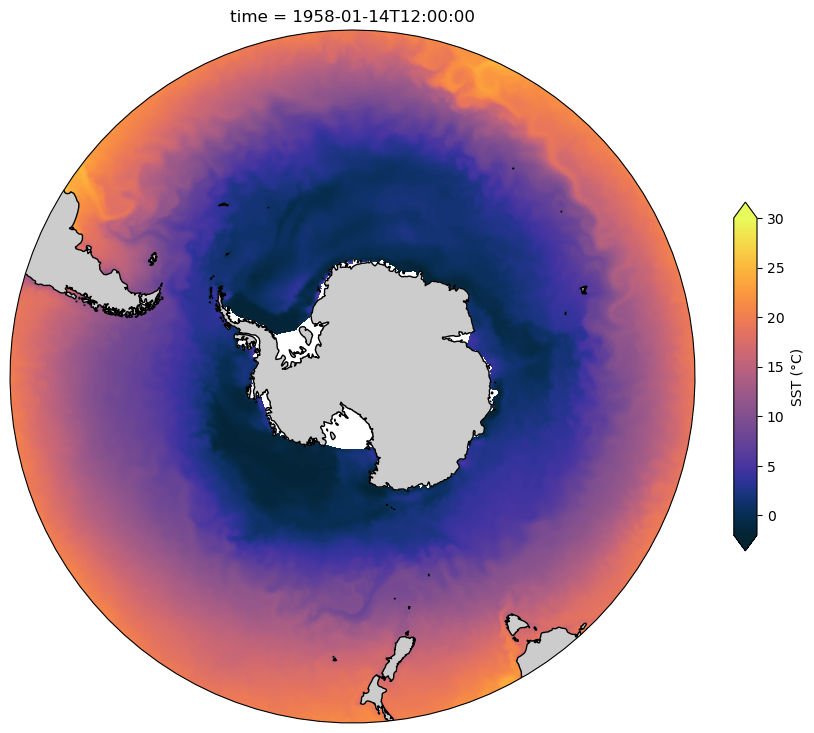

In [40]:
projection = ccrs.SouthPolarStereo()

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.

import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

SST.plot(
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

### Mercator regional plot

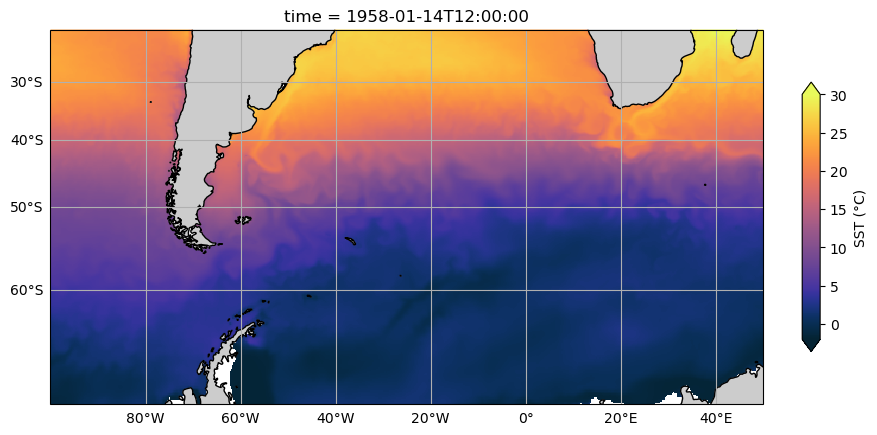

In [36]:
projection = ccrs.Mercator(
    central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0
)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

SST.plot(
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False   # turn off top labels
gl.right_labels = False # turn off right labels

### Sector map

This map shows a sector of the Southern Ocean. It involves a Stereographic projection and a fairly complicated cutout to set the boundary of the map, but gives a nice result.

In [41]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

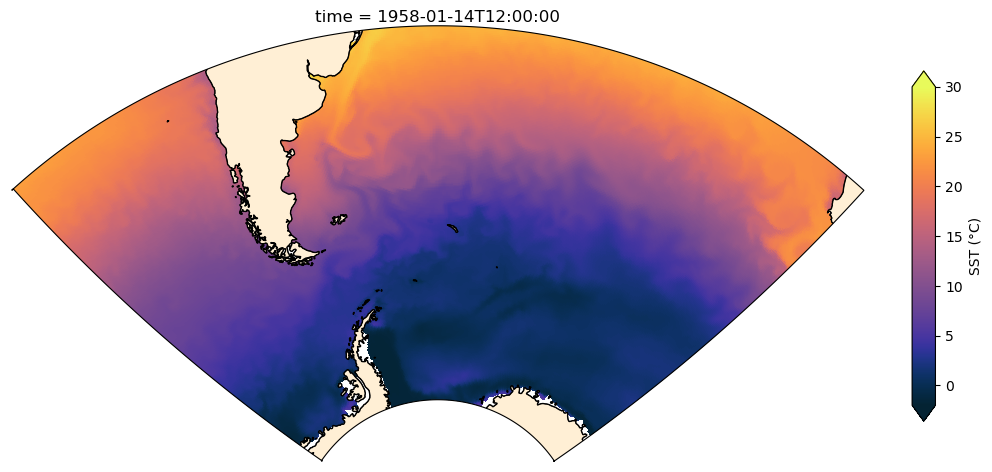

In [45]:
midlon = -40
maxlon = midlon + 60
minlon = midlon - 60
minlat = -75
maxlat = -30
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

lons = geolon_t.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = geolat_t.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

SST.plot(
    x="geolon_t",
    y="geolat_t",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

You can see a wider selection of cartopy's projections in the package's [documentation](https://scitools.org.uk/cartopy/docs/latest).

### Use model's land mask

Notice above, that near Antarctica (e.g., near the peninsula), there are some points where the model does not have sea-surface temperature values. This is particularly evident in the `SouthPolarStereo` projection above. The reason for that is that the coastline used by cartopy isn't exactly the same as the one used by the models. The model mask is very different from the cartopy's land mask, e.g., near Antarctica, due to the differences where the ice shelves are.

To use the model-specific land mask, first load the bathymetry for your experiment. For MOM5 output, `ht` is the bathymetry on the t grid while `hu` is the bathymetry on the u grid.

In [48]:
experiment = "025deg_jra55_iaf_omip2_cycle6"  # or, e.g., '1deg_jra55_iaf_omip2_cycle6' or '01deg_jra55v140_iaf_cycle3'

var_search = catalog[experiment].search(variable="ht")
ds = var_search.search(
    path=var_search.df.path[0] # we only need one file as bathymetry doesn't change
).to_dask()
bathymetry = ds["ht"].load()

land = xr.where(np.isnan(bathymetry.rename("land")), 1, np.nan)
land = land.assign_coords({"geolon_t": geolon_t, "geolat_t": geolat_t})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Create a land mask for plotting, set land cells to 1 and rest to NaN. This is preferred over `cartopy.feature`, because the land that `cartopy.feature` provides differs from the model's land mask.

And now plot!

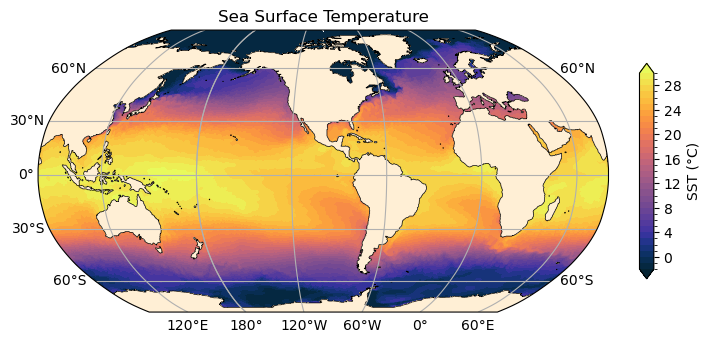

In [49]:
fig = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Add model land mask
land.plot.contourf(
    ax=ax,
    x="geolon_t",
    y="geolat_t",
    colors="papayawhip",
    zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False
)

# Add model coastline
land.fillna(0).plot.contour(
    ax=ax,
    x="geolon_t",
    y="geolat_t",
    colors="k",
    levels=[0, 1],
    transform=ccrs.PlateCarree(), add_colorbar=False,
    linewidths=0.5,
)

SST.plot.contourf(
    ax=ax,
    x="geolon_t",
    y="geolat_t",
    levels=33,
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False   # turn off top labels
gl.right_labels = False # turn off right labels

plt.title("Sea Surface Temperature");

### NASA's Blue Marble as Land

NASA's Blue Marble is much better land compared to a dull plain colour. Let's see how we can add that!

In [51]:
map_path = "/g/data/ik11/grids/BlueMarble.tiff"
blue_marble = plt.imread(map_path)
blue_marble_extent = (-180, 180, -90, 90)

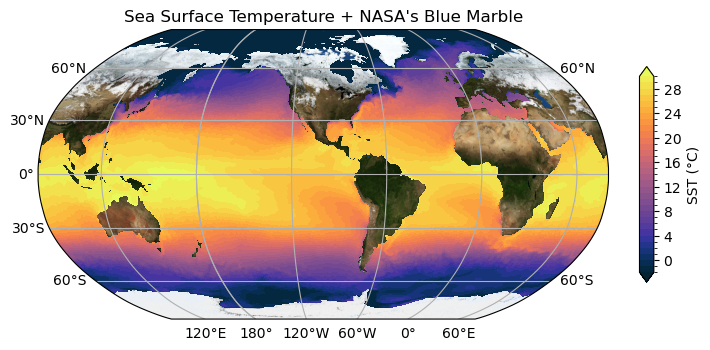

In [52]:
fig = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

SST.plot.contourf(
    ax=ax,
    x="geolon_t",
    y="geolat_t",
    levels=33,
    vmin=-2,
    vmax=30,
    extend="both",
    cmap=cm.cm.thermal,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)

# Add blue marble land:
ax.imshow(
    blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False   # turn off top labels
gl.right_labels = False # turn off right labels

plt.title("Sea Surface Temperature + NASA's Blue Marble");